### Importing Libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
import math
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


### Pre-processing - Training and Testing sets

In [ ]:

# Paths
base_dir = '/content/drive/MyDrive/Discipline Specific /4th Model/Preprocessed Non Cancerous '

# Hyperparams
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-4
NUM_CLASSES = 4  # (vasc, nv, df, bkl)

#############################
# 2. DATA GENERATORS
#############################
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("Class indices:", train_generator.class_indices)


### Building the EfficientnetB3 Model

In [ ]:
#BUILD MODEL

base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=LR),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


#TRAINING THE MODEL

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy',
                             save_best_only=True, mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,
                           restore_best_weights=True)
callbacks_list = [checkpoint, early_stop]

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

### Evaluation Metrics - Performance of the Model

Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Class indices: {'bkl': 0, 'df': 1, 'nv': 2, 'vasc': 3}
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,689,988 (98.00 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.5960 - loss: 1.1410 
Epoch 1: val_accuracy improved from -inf to 0.77625, saving model to best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 2346s 23s/step - accuracy: 0.5975 - loss: 1.1367 - val_accuracy: 0.7763 - val_loss: 0.6676
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8946 - loss: 0.2957
Epoch 2: val_accuracy did not improve from 0.77625
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 228ms/step - accuracy: 0.8946 - loss: 0.2956 - val_accuracy: 0.7738 - val_loss: 0.6477
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9285 - loss: 0.2095
Epoch 3: val_accuracy improved from 0.77625 to 0.83250, saving model to best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.9284 - loss: 0.2096 - val_accuracy: 0.8325 - val_loss: 0.5648
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9445 - loss: 0.1646
Epoch 4: val_accuracy did not improve from 0.83250
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.9444 - loss: 0.1647 - val_accuracy: 0.8213 - val_loss: 0.5475
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9602 - loss: 0.1301
Epoch 5: val_accuracy did not improve from 0.83250
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 224ms/step - accuracy: 0.9602 - loss: 0.1302 - val_accuracy: 0.8175 - val_loss: 0.6091
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9650 - loss: 0.1107
Epoch 6: val_accuracy improved from 0.83250 to 0.85125, saving model to best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 233ms/step - accuracy: 0.9650 - loss: 0.1108 - val_accuracy: 0.8512 - val_loss: 0.5073
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9696 - loss: 0.0964
Epoch 7: val_accuracy did not improve from 0.85125
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 228ms/step - accuracy: 0.9696 - loss: 0.0964 - val_accuracy: 0.8462 - val_loss: 0.4937
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9669 - loss: 0.0929
Epoch 8: val_accuracy did not improve from 0.85125
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 228ms/step - accuracy: 0.9669 - loss: 0.0928 - val_accuracy: 0.8512 - val_loss: 0.5280
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9809 - loss: 0.0652
Epoch 9: val_accuracy improved from 0.85125 to 0.86000, saving model to best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 240ms/step - accuracy: 0.9808 - loss: 0.0653 - val_accuracy: 0.8600 - val_loss: 0.5136
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9837 - loss: 0.0589
Epoch 10: val_accuracy improved from 0.86000 to 0.86375, saving model to best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step - accuracy: 0.9837 - loss: 0.0589 - val_accuracy: 0.8637 - val_loss: 0.5683
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9907 - loss: 0.0463
Epoch 11: val_accuracy improved from 0.86375 to 0.87750, saving model to best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 234ms/step - accuracy: 0.9907 - loss: 0.0464 - val_accuracy: 0.8775 - val_loss: 0.4878
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9860 - loss: 0.0512
Epoch 12: val_accuracy improved from 0.87750 to 0.88000, saving model to best_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step - accuracy: 0.9861 - loss: 0.0512 - val_accuracy: 0.8800 - val_loss: 0.4801
Epoch 13/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9892 - loss: 0.0430
Epoch 13: val_accuracy did not improve from 0.88000
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 228ms/step - accuracy: 0.9892 - loss: 0.0430 - val_accuracy: 0.8612 - val_loss: 0.5460
Epoch 14/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9915 - loss: 0.0379
Epoch 14: val_accuracy did not improve from 0.88000
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 227ms/step - accuracy: 0.9915 - loss: 0.0379 - val_accuracy: 0.8587 - val_loss: 0.6183
Epoch 15/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9951 - loss: 0.0308
Epoch 15: val_accuracy did not improve from 0.88000
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.9951 - loss: 0.0308 - val_accuracy: 0.8650 - val_loss: 0.6007
Epoch 16/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9968 - loss: 0.0285
Epoch 16

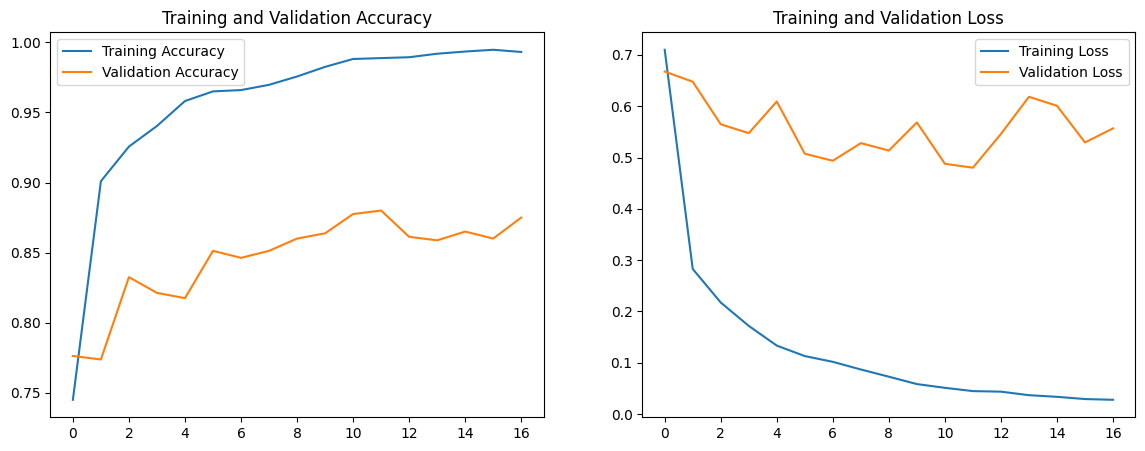

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step


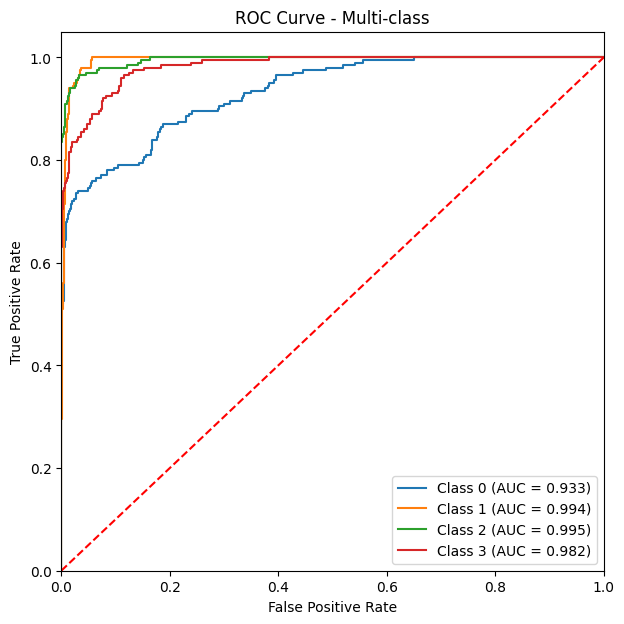

In [ ]:
#PLOT ACCURACY & LOSS

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# EVALUATE AUC-ROC

valid_generator.reset()
y_pred_proba = model.predict(valid_generator)
y_true = valid_generator.classes
y_true_bin = label_binarize(y_true, classes=[0,1,2,3])

plt.figure(figsize=(7,7))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Class {} (AUC = {:.3f})'.format(i, roc_auc))

plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-class')
plt.legend(loc='lower right')
plt.show()


### Confusion Matrix and Classifcation Report

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step
Confusion Matrix:
[[139   0   9  52]
 [  0 191   1   8]
 [  8   3 188   1]
 [  0  14   0 186]]


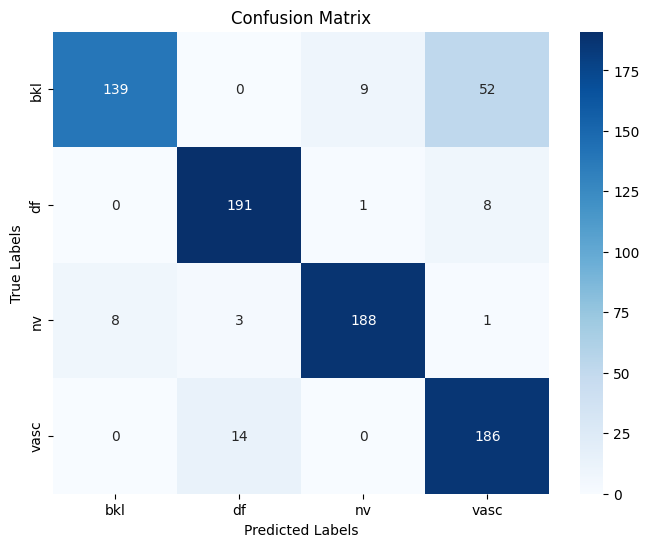

Classification Report:
              precision    recall  f1-score   support

         bkl       0.95      0.69      0.80       200
          df       0.92      0.95      0.94       200
          nv       0.95      0.94      0.94       200
        vasc       0.75      0.93      0.83       200

    accuracy                           0.88       800
   macro avg       0.89      0.88      0.88       800
weighted avg       0.89      0.88      0.88       800



In [ ]:
# Ensure the generator is reset to predict the entire validation set
valid_generator.reset()

# Calculate the number of steps (ceil to include all samples)
steps = math.ceil(valid_generator.samples / valid_generator.batch_size)

# Predict the probabilities for the validation set and then the class indices
y_pred = model.predict(valid_generator, steps=steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from the generator
y_true = valid_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Get class names in the correct order from the generator mapping
target_names = [None] * len(train_generator.class_indices)
for key, value in train_generator.class_indices.items():
    target_names[value] = key

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Generate and print the classification report
report = classification_report(y_true, y_pred_classes, target_names=target_names)
print("Classification Report:")
print(report)
